In [1]:
import pandas as pd
import torch
import os
from matplotlib import pyplot as plt
from main import target_renamer, forecast_maker, data_slicer
from Models.lstm import LSTM
from Data.Featurisation import Featurisation

In [2]:
lags = 24
forecast_period=24
hidden_size = 100
num_layers = 4
dropout = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
month_data = True #1 month of data for testing new code

month_range = pd.date_range("2019-08-01", "2019-08-31 23:00", freq='h', tz="UTC")
source_range = pd.date_range("2016-05-01","2019-12-31 23:00", freq='h', tz="UTC")
target_month = pd.date_range("2020-08-01", "2020-08-31 23:00", freq='h', tz="UTC")
eval_month = pd.date_range("2020-09-01", "2021-07-31 23:00", tz="UTC", freq='h')

# 0. Data initialization

In [4]:
openmeteo = pd.read_pickle("Data/openmeteo.pickle")

pvgis = pd.read_pickle('Data/PVGIS.pickle')

CEDA = pd.read_pickle("CEDA_dataNL.pickle")
is_day = pd.read_pickle("Data/is_day.pickle")

meteo2CEDA = {'temperature_2m' :'temperature_1_5m', 
              "relative_humidity_2m":"relative_humidity_1_5m", 
              "pressure_msl": "pressure_MSL",
              "cloud_cover":"total_cloud_amount",
              "shortwave_radiation": "downward_surface_SW_flux",
              "diffuse_radiation":"diffuse_surface_SW_flux",
              "direct_normal_irradiance":"direct_surface_SW_flux",
              "wind_speed_10m": "wind_speed_10m",
              "wind_direction_10m": "wind_direction_10m"
              }
openmeteo = openmeteo.rename(columns=meteo2CEDA)


In [5]:
openmeteo

,temperature_1_5m,relative_humidity_1_5m,pressure_MSL,total_cloud_amount,wind_speed_10m,wind_direction_10m,downward_surface_SW_flux,diffuse_surface_SW_flux,direct_surface_SW_flux
date,,,,,,,,,
2016-05-01 00:00:00+00:00,276.830505,89.285660,1025.300049,0.000,3.101613,358.152435,0.0,0.0,0.000000
2016-05-01 01:00:00+00:00,276.330505,90.854256,1025.800049,0.000,2.507987,4.573841,0.0,0.0,0.000000
2016-05-01 02:00:00+00:00,275.980499,91.482162,1026.199951,0.021,2.800000,360.000000,0.0,0.0,0.000000
2016-05-01 03:00:00+00:00,275.780487,91.797310,1026.199951,0.102,3.301515,1.735665,0.0,0.0,0.000000
2016-05-01 04:00:00+00:00,275.730499,91.794098,1026.599976,0.180,2.630589,8.746089,21.0,12.0,97.652107
...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,284.830505,93.275887,1019.500000,0.459,5.693857,239.381470,0.0,0.0,0.000000
2021-12-31 20:00:00+00:00,284.580505,95.145828,1020.400024,1.000,6.307139,244.653870,0.0,0.0,0.000000
2021-12-31 21:00:00+00:00,284.880493,94.213600,1021.200012,1.000,6.293648,252.428650,0.0,0.0,0.000000


52.0499 5.07391 3100 5 33
                               P
timestamp                       
2019-01-10 15:00:00+00:00    0.0
2019-01-10 16:00:00+00:00    0.0
2019-01-10 17:00:00+00:00    0.0
2019-01-10 18:00:00+00:00    0.0
2019-01-10 19:00:00+00:00    0.0
...                          ...
2021-08-09 16:00:00+00:00  954.0
2021-08-09 17:00:00+00:00  337.0
2021-08-09 18:00:00+00:00  100.0
2021-08-09 19:00:00+00:00    5.0
2021-08-09 20:00:00+00:00    0.0

[22614 rows x 1 columns]


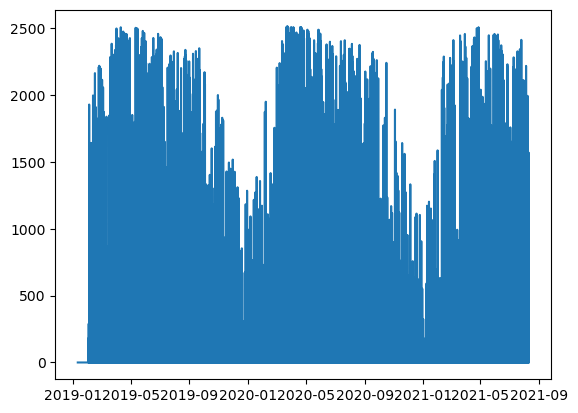

In [6]:
installation_id = "3437BD60"
prodNL = pd.read_parquet('Data/production.parquet', engine='pyarrow')
metadata = pd.read_csv("Data/installations Netherlands.csv", sep=';')
metadata = metadata.set_index('id')
metadata_id = metadata.loc[installation_id]
tilt = metadata_id["Tilt"]
peakPower = metadata_id["Watt Peak"]
azimuth = metadata_id["Orientation"]
latitude = metadata_id["Latitude"]
longitude = metadata_id["Longitude"]
power = prodNL.loc[installation_id]
power = target_renamer(power, 'watt')
power = power.resample('h').sum()/4
power = power.tz_localize('UTC')
#power.index = power.index.shift(periods=2)
print(latitude, longitude, peakPower, azimuth, tilt)
plt.plot(power)
print(power)


In [7]:
#target and evaluation data will stay the same most probablyy
target_CEDA = data_slicer(CEDA, target_month)
target_power = data_slicer(power, target_month)
eval_CEDA = data_slicer(CEDA, eval_month)
eval_power = data_slicer(power, eval_month)

#TARGET DATASET
data = pd.merge(target_power, target_CEDA, left_index=True, right_index=True, how='inner')
data = pd.merge(data, is_day, right_index=True, left_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')
data.data = data.PoA(latitude, longitude, tilt, azimuth)
data.data = data.remove_outliers(tolerance=50)

target_dataset = data.data[0]

## EVALUATION DATASET
data = pd.merge(eval_power, eval_CEDA, left_index=True, right_index=True, how='inner')
data = pd.merge(data, is_day, right_index=True, left_index=True)
data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')
data.data = data.PoA(latitude, longitude, tilt, azimuth)
data.data = data.remove_outliers(tolerance=50)


eval_dataset = data.data[0]
print(eval_dataset)


                              P  temperature_1_5m  relative_humidity_1_5m  \
2020-09-01 00:00:00+00:00   0.0        283.621826               91.747078   
2020-09-01 01:00:00+00:00   0.0        283.621826               91.747078   
2020-09-01 02:00:00+00:00   0.0        283.178223               93.100021   
2020-09-01 03:00:00+00:00   0.0        282.962402               94.491180   
2020-09-01 04:00:00+00:00   0.0        283.078369               93.862251   
...                         ...               ...                     ...   
2021-07-31 19:00:00+00:00  27.0        291.173584               77.048073   
2021-07-31 20:00:00+00:00   0.0        290.445068               80.800293   
2021-07-31 21:00:00+00:00   0.0        289.452637               85.674126   
2021-07-31 22:00:00+00:00   0.0        289.241455               85.317856   
2021-07-31 23:00:00+00:00   0.0        288.321045               92.201263   

                           total_cloud_amount  diffuse_surface_SW_flux  \
2

# 1. NWP data

Case study 1:
|   | Source   | Target |
|---|----------|--------|
| X | CEDA | CEDA|
| Y | PVGIS    | Prod NL|

In [8]:
from Data.Featurisation import Featurisation

source_pvgis = data_slicer(pvgis, source_range)
source_CEDA = data_slicer(CEDA, source_range)


data = pd.merge(source_pvgis, source_CEDA, left_index=True, right_index=True)
data = pd.merge(data, is_day, right_index=True, left_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')
data.data = data.PoA(latitude, longitude, tilt, azimuth)
data.data = data.remove_outliers(tolerance=50)
data.data = data.inverter_limit(2500)

source_dataset = data.data[0]
if month_data:
    source_dataset = source_dataset[source_dataset.index.isin(month_range)]

min = source_dataset.min(axis=0).to_dict()
max = source_dataset.max(axis=0).to_dict()



In [9]:
print((source_dataset.corr()-eval_dataset.corr()).loc['P'])
print(source_dataset.corr().loc['P'])
print(eval_dataset.corr().loc['P'])


P                           0.000000
temperature_1_5m            0.226569
relative_humidity_1_5m     -0.038377
total_cloud_amount          0.281683
diffuse_surface_SW_flux    -0.009334
direct_surface_SW_flux     -0.001935
downward_surface_SW_flux   -0.003932
pressure_MSL               -0.013435
wind_speed_10m              0.144077
wind_direction_10m          0.121295
is_day                      0.031880
hour_sin                    0.008280
hour_cos                   -0.164572
month_sin                        NaN
month_cos                        NaN
P_24h_shift                 0.032335
wind_direction_10m_cos      0.159247
wind_direction_10m_sin      0.140346
PoA                        -0.007204
Name: P, dtype: float64
P                           1.000000
temperature_1_5m            0.583900
relative_humidity_1_5m     -0.673472
total_cloud_amount          0.074056
diffuse_surface_SW_flux     0.732463
direct_surface_SW_flux      0.792022
downward_surface_SW_flux    0.902100
pressure_MSL  

In [10]:
tuning_method = 'freeze'
features = list(source_dataset.columns)
features = ['P', 'temperature_1_5m', 'relative_humidity_1_5m', 'diffuse_surface_SW_flux', 'direct_surface_SW_flux', 'downward_surface_SW_flux', 'PoA', 'P_24h_shift', "is_day"]
print(features)

['P', 'temperature_1_5m', 'relative_humidity_1_5m', 'diffuse_surface_SW_flux', 'direct_surface_SW_flux', 'downward_surface_SW_flux', 'PoA', 'P_24h_shift', 'is_day']


Shape of data:  torch.Size([24, 24, 8]) torch.Size([6, 24, 8]) torch.Size([24, 24, 1]) torch.Size([6, 24, 1])
Step 0: Average train loss: 0.1267 | Average test loss: 0.1620
Step 5: Average train loss: 0.0830 | Average test loss: 0.1066
Step 10: Average train loss: 0.0827 | Average test loss: 0.1132
Step 15: Average train loss: 0.0808 | Average test loss: 0.1058
Step 20: Average train loss: 0.0799 | Average test loss: 0.1092
Step 25: Average train loss: 0.0759 | Average test loss: 0.1052
Step 30: Average train loss: 0.0582 | Average test loss: 0.0744
Step 35: Average train loss: 0.0515 | Average test loss: 0.0721
Step 40: Average train loss: 0.0499 | Average test loss: 0.0692
Step 45: Average train loss: 0.0466 | Average test loss: 0.0612
Step 50: Average train loss: 0.0338 | Average test loss: 0.0554
Step 55: Average train loss: 0.0389 | Average test loss: 0.0503
Step 60: Average train loss: 0.0320 | Average test loss: 0.0463
Step 65: Average train loss: 0.0331 | Average test loss: 0.0

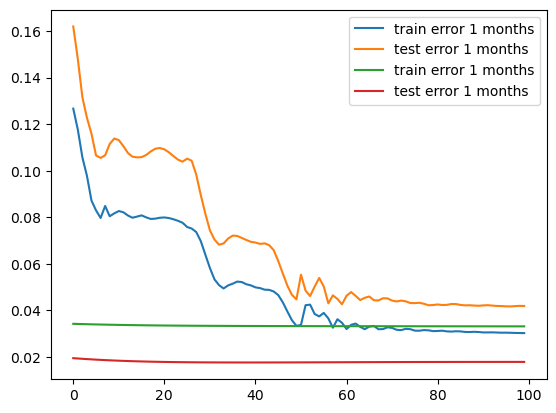

In [11]:
source_state_dict, target_state_dict, y_truth, y_forecast = forecast_maker(source_dataset, target_dataset, features, eval_dataset, [min,max])

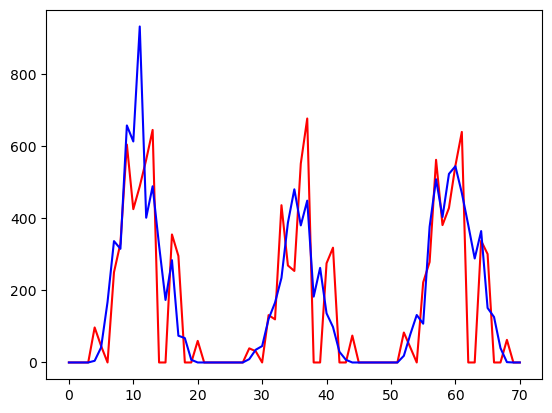

In [20]:
plt.figure()

day = 300
plt.plot(y_forecast[(24*day):(24*day)+71], color='red')
plt.plot(y_truth[(24*day):(24*day)+71], color='blue')

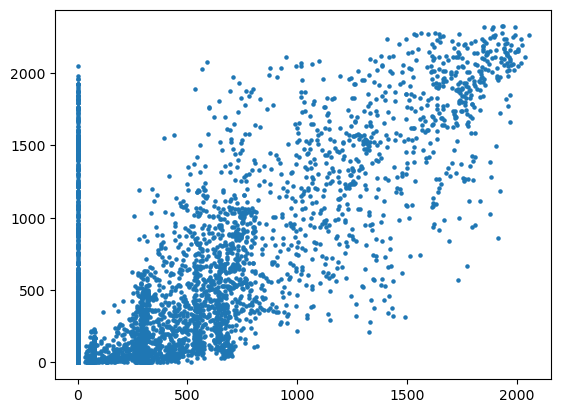

In [13]:
plt.scatter(y_forecast, y_truth, s=5)

# 2. Historic weather 

Case study 2:
|   | Source   | Target |
|---|----------|--------|
| X |open-meteo| open-meteo|
| Y | PVGIS    | Prod NL|

We check if the model is skillful, by comparing its performance if actual weather data is used

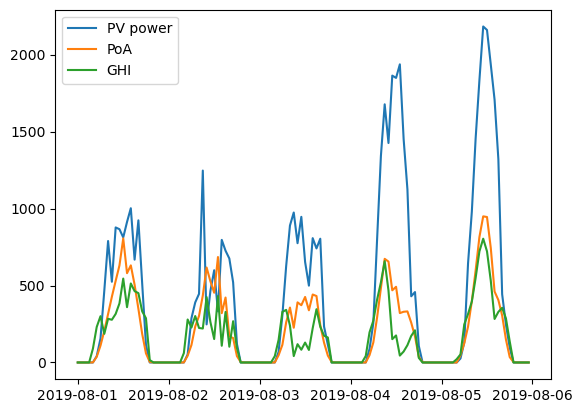

In [14]:
from Data.Featurisation import Featurisation

source_pvgis = data_slicer(pvgis, source_range)
source_openmeteo = data_slicer(openmeteo, source_range)
source_power = data_slicer(power, month_range)

data = pd.merge(source_pvgis, source_openmeteo, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')
data.data = data.PoA(latitude, longitude, tilt, azimuth)

source_dataset = data.data[0]
if month_data:
    source_dataset = source_dataset[source_dataset.index.isin(month_range)]

min = source_dataset.min(axis=0).to_dict()
max = source_dataset.max(axis=0).to_dict()

target_openmeteo = data_slicer(openmeteo, target_month)
eval_openmeteo = data_slicer(openmeteo, eval_month)

#TARGET
data = pd.merge(target_power, target_openmeteo, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')
data.data = data.PoA(latitude, longitude, tilt, azimuth)

target_dataset = data.data[0]
#EVAL
data = pd.merge(eval_power, eval_openmeteo, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')
data.data = data.PoA(latitude, longitude, tilt, azimuth)

eval_dataset = data.data[0]

plt.figure()
plt.plot(source_dataset['P']["2019-08-01":"2019-08-05"], label='PV power')
plt.plot(source_dataset['PoA']["2019-08-01":"2019-08-05"], label='PoA')
plt.plot(source_dataset['direct_surface_SW_flux']["2019-08-01":"2019-08-05"], label = 'GHI')
plt.legend()

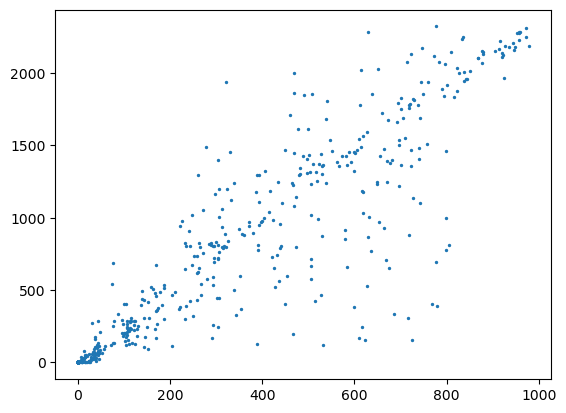

In [15]:
plt.figure()
plt.scatter(source_dataset["PoA"],source_dataset['P'], s=2)
plt.show()

In [16]:
tuning_method = 'whole'
features = list(source_dataset.columns)
features= ['P', 'temperature_1_5m', 'relative_humidity_1_5m', 'total_cloud_amount', 'wind_speed_10m', 'downward_surface_SW_flux', 'diffuse_surface_SW_flux', 'direct_surface_SW_flux', 'PoA', "is_day"]
print(features)


['P', 'temperature_1_5m', 'relative_humidity_1_5m', 'total_cloud_amount', 'wind_speed_10m', 'downward_surface_SW_flux', 'diffuse_surface_SW_flux', 'direct_surface_SW_flux', 'PoA', 'is_day']


In [17]:
source_dataset = source_dataset.astype(float)

In [18]:
source_state_dict, target_state_dict, y_truth, y_forecast = forecast_maker(source_dataset, target_dataset, features, eval_dataset, [min,max])

KeyError: 'is_day'

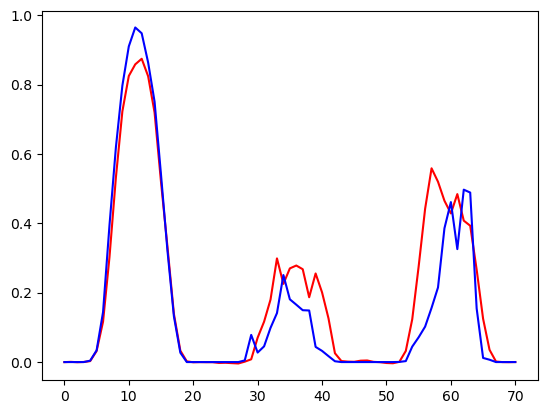

In [ ]:
plt.figure()

day =300
plt.plot(y_forecast[(24*day):(24*day)+71], color='red')
plt.plot(y_truth[(24*day):(24*day)+71], color='blue')

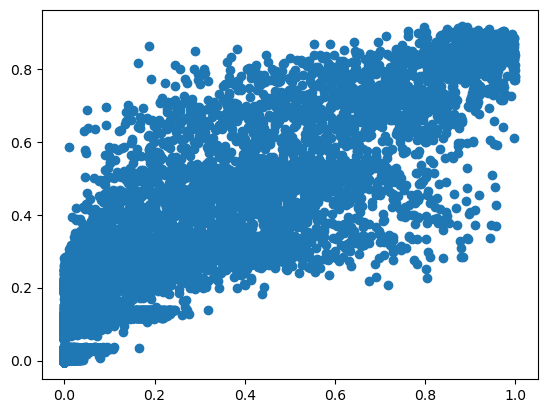

In [ ]:
plt.figure()
plt.scatter(y_truth, y_forecast)
